---
# Carregar Dataset
---

In [463]:
import numpy as np
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
import statistics
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, KFold, train_test_split,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
#from tensorflow.keras.models  import Sequential
#from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

RANDOM_SEED = 2022

In [464]:
df = pd.read_csv("training_data.csv")
df_test = pd.read_csv("test_data.csv")

---
# Exploração de dados
---

- **city_name** - nome da cidade em causa;
- **record_date** - o timestamp associado ao registo;
- **magnitude_of_delay** - magnitude do atraso provocado pelos incidentes que se verificam no record_date correspondente;
- **delay_in_seconds** - atraso, em segundos, provocado pelos incidentes que se verificam no record_date correspondente;
- **affected_roads** - estradas afectadas pelos incidentes que se verificam no record_date correspondente;
- **luminosity** - o nível de luminosidade que se verificava na cidade de Guimarães;
- **avg_temperature** - valor médio da temperatura para o record_date na cidade de Guimarães;
- **avg_atm_pressure** - valor médio da pressão atmosférica para o record_date na cidade de Guimarães;
- **avg_humidity** - valor médio de humidade para o record_date na cidade de Guimarães;
- **avg_wind_speed** - valor médio da velocidade do vento para o record_date na cidade de Guimarães;
- **avg_precipitation** - valor médio de precipitação para o record_date na cidade de Guimarães;
- **avg_rain** - avaliação qualitativa do nível de precipitação para o record_date na cidade de Guimarães;
- **incidents** - indicação acerca do nível de incidentes rodoviários que se verificam no record_date correspondente na cidade de Guimarães.

In [465]:
df.columns

Index(['city_name', 'magnitude_of_delay', 'delay_in_seconds', 'affected_roads',
       'record_date', 'luminosity', 'avg_temperature', 'avg_atm_pressure',
       'avg_humidity', 'avg_wind_speed', 'avg_precipitation', 'avg_rain',
       'incidents'],
      dtype='object')

In [466]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           5000 non-null   object 
 1   magnitude_of_delay  5000 non-null   object 
 2   delay_in_seconds    5000 non-null   int64  
 3   affected_roads      4915 non-null   object 
 4   record_date         5000 non-null   object 
 5   luminosity          5000 non-null   object 
 6   avg_temperature     5000 non-null   float64
 7   avg_atm_pressure    5000 non-null   float64
 8   avg_humidity        5000 non-null   float64
 9   avg_wind_speed      5000 non-null   float64
 10  avg_precipitation   5000 non-null   float64
 11  avg_rain            5000 non-null   object 
 12  incidents           5000 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 507.9+ KB


In [467]:
df.head()

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0.0,Sem Chuva,None
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0.0,Sem Chuva,None
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0.0,Sem Chuva,Low
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0.0,Sem Chuva,Very_High
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0.0,Sem Chuva,High


In [468]:
print("------------\n" + "Value counts (incidents):\n\n" + df['incidents'].value_counts().to_string() + "\n------------\n")

for s in ['city_name','magnitude_of_delay','luminosity','avg_rain']:
    print("------------\n" + "Value counts (" + s + "):\n\n" + "training dataset:\n" + df[s].value_counts().to_string() + 
          "\n\ntest dataset:\n" + df_test[s].value_counts().to_string() + "\n------------\n")

------------
Value counts (incidents):

None         2028
High         1073
Low           718
Very_High     603
Medium        578
------------

------------
Value counts (city_name):

training dataset:
Guimaraes    5000

test dataset:
Guimaraes    1206
------------

------------
Value counts (magnitude_of_delay):

training dataset:
UNDEFINED    4314
MAJOR         678
MODERATE        8

test dataset:
UNDEFINED    1030
MAJOR         175
MODERATE        1
------------

------------
Value counts (luminosity):

training dataset:
DARK         2489
LIGHT        2325
LOW_LIGHT     186

test dataset:
DARK         623
LIGHT        546
LOW_LIGHT     37
------------

------------
Value counts (avg_rain):

training dataset:
Sem Chuva         4756
chuva fraca        214
chuva moderada      27
chuva forte          3

test dataset:
Sem Chuva         1140
chuva fraca         56
chuva moderada       8
chuva forte          2
------------



In [469]:
print("training dataset:" ,df['avg_precipitation'].value_counts())
print("\ntest dataset:" ,df['avg_precipitation'].value_counts())

training dataset: 0.0    5000
Name: avg_precipitation, dtype: int64

test dataset: 0.0    5000
Name: avg_precipitation, dtype: int64


In [470]:
#Values are always the same (irrelevant features)
df.drop(['city_name','avg_precipitation'], axis=1, inplace=True)
df_test.drop(['city_name','avg_precipitation'], axis=1, inplace=True)

In [471]:
df.describe()

,delay_in_seconds,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,560.567000,14.583000,1018.145000,74.455000,1.253500
std,1686.859581,4.820514,5.174372,17.204638,1.269847
min,0.000000,1.000000,997.000000,6.000000,0.000000
25%,0.000000,11.000000,1015.000000,63.000000,0.000000
50%,0.000000,14.000000,1019.000000,78.000000,1.000000
75%,234.000000,18.000000,1022.000000,90.000000,2.000000
max,31083.000000,35.000000,1032.000000,100.000000,10.000000


In [472]:
print(f"Skewness: \n{df.skew()}")
print(f"\nKurtosis: \n{df.kurt()}")

Skewness: 
delay_in_seconds    6.274561
avg_temperature     0.560506
avg_atm_pressure   -0.404397
avg_humidity       -0.762679
avg_wind_speed      1.361024
dtype: float64

Kurtosis: 
delay_in_seconds    63.136555
avg_temperature      0.532773
avg_atm_pressure     0.120680
avg_humidity        -0.249918
avg_wind_speed       2.516310
dtype: float64


/tmp/ipykernel_25846/932093429.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(f"Skewness: \n{df.skew()}")
/tmp/ipykernel_25846/932093429.py:2: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(f"\nKurtosis: \n{df.kurt()}")


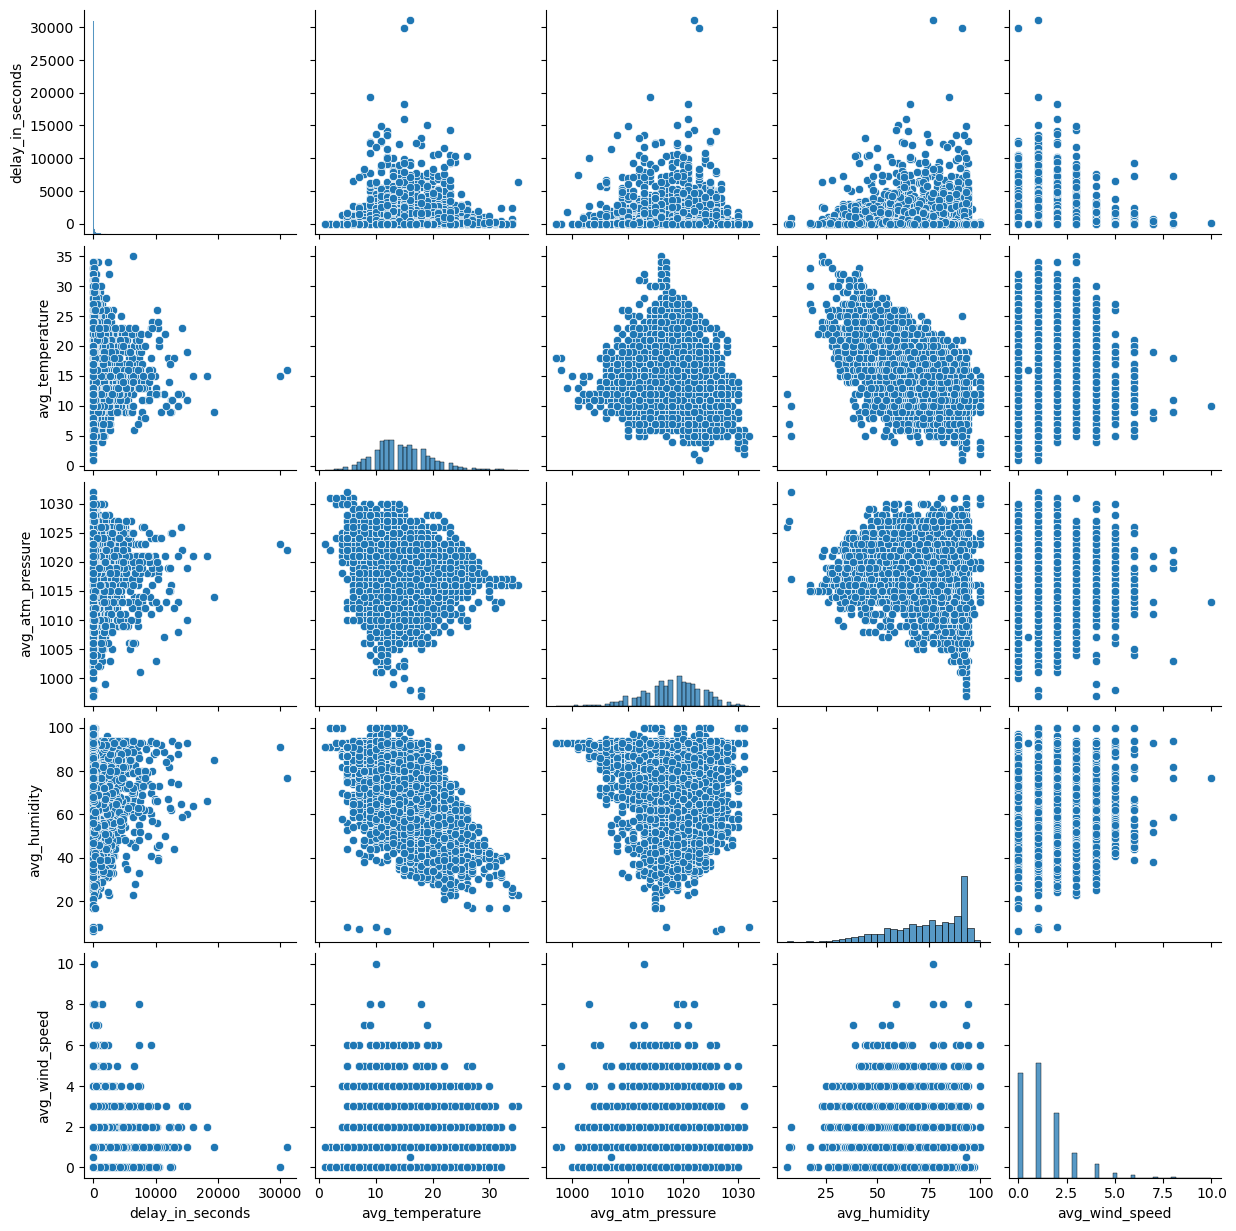

In [473]:
sns.pairplot(df)

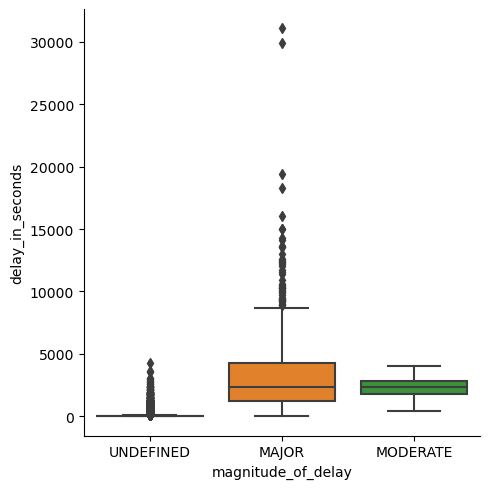

In [474]:
sns.catplot(y='delay_in_seconds', x='magnitude_of_delay', data=df, kind='box')

/tmp/ipykernel_25846/1826249297.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<AxesSubplot:>

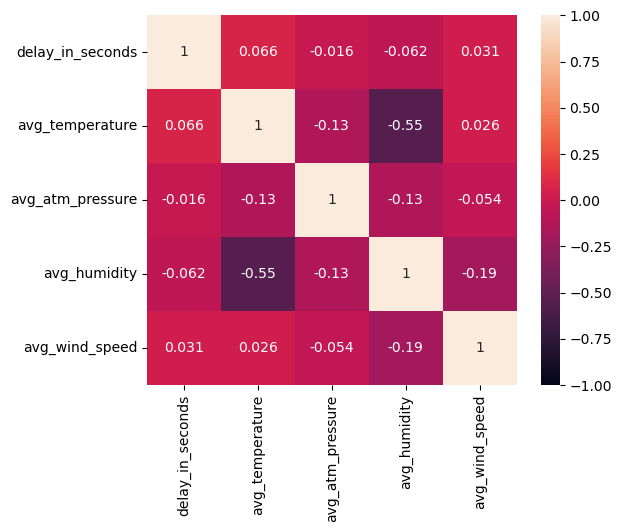

In [475]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True)
#Strong correlation between the features avg_temperature and avg_humidity

In [476]:
#Only the feature affected_roads has missing values
df.isna().sum()

magnitude_of_delay     0
delay_in_seconds       0
affected_roads        85
record_date            0
luminosity             0
avg_temperature        0
avg_atm_pressure       0
avg_humidity           0
avg_wind_speed         0
avg_rain               0
incidents              0
dtype: int64

----------
* Tratamento das roads

In [477]:
#Function to remove duplicate roads
import re
def updateRoadSet(val,setRoads):
    #pattern = re.compile(",?(\w[ \w\-]*\w|\w),?")
    pattern = re.compile("\,?(\w[\w\-]*\w|\w)\,?")
    lista = re.findall(pattern,val)
    
    for road in lista:
        setRoads.add(road)

In [478]:
# Remover roads duplicadas
setRoads = set()
df['affected_roads'].fillna(",").apply(updateRoadSet,args=(setRoads,))
df_test['affected_roads'].fillna(",").apply(updateRoadSet,args=(setRoads,))

print(setRoads)

{'N206', 'IC5', 'N207-4', 'N310', 'N101', 'N309', 'R206', 'N105', 'EM579'}


In [479]:
for road in setRoads:
    df[road] = 0
    df_test[road] = 0

In [480]:
import re
def get_roads(roads_string : str):
    #pattern = re.compile(",?(\w[ \w\-]*\w|\w),?")
    pattern = re.compile("\,?(\w[\w\-]*\w|\w)\,?")
    l = re.findall(pattern,roads_string)
    roads = dict()
    for r in l:
        road_count = roads.get(r)
        if(road_count != None):
            roads[r] = road_count + 1
        else:
            roads[r] = 1
    return roads

In [481]:
#For train dataset
for i in range (0, df.shape[0]):
    row = df.iloc[i]
    roads_string = str(row['affected_roads'])
    roads = get_roads(roads_string)
    for road,counter in roads.items():
        if(road!="nan"):
           df.at[i, road] = counter
           #df.at[i, road] = 1

#For test dataset
for i in range (0, df_test.shape[0]):
    row = df_test.iloc[i]
    roads_string = str(row['affected_roads'])
    roads = get_roads(roads_string)
    for road,counter in roads.items():
        if(road!="nan"):
           df_test.at[i, road] = counter

In [482]:
df

,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,N206,IC5,N207-4,N310,N101,N309,R206,N105,EM579
0,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,Sem Chuva,None,0,0,0,0,0,0,0,0,0
1,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,Sem Chuva,None,0,0,0,0,1,0,0,0,0
2,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,Sem Chuva,Low,0,0,0,0,0,0,0,0,0
3,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,Sem Chuva,Very_High,0,0,0,0,9,0,1,1,0
4,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,Sem Chuva,High,0,0,0,0,5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-04-13 00:00,DARK,13.0,1021.0,56.0,0.0,Sem Chuva,High,0,0,0,0,5,0,0,0,0
4996,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-07-06 14:00,LIGHT,19.0,1017.0,68.0,0.0,Sem Chuva,None,0,0,0,0,5,0,0,0,0
4997,UNDEFINED,0,",",2021-03-18 03:00,DARK,13.0,1023.0,47.0,2.0,Sem Chuva,None,0,0,0,0,0,0,0,0,0
4998,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-11-02 06:00,DARK,12.0,1014.0,93.0,2.0,Sem Chuva,None,0,0,0,0,5,0,0,0,0


----------
* Tratamento dos duplicados

In [483]:
#No duplicated entries
df.duplicated().value_counts()

False    5000
dtype: int64

---
# Tratamento dos dados
---

In [484]:
#'affected roads' separar as entradas em várias por cada estrada
df.drop(['affected_roads'], axis=1, inplace=True)
df_test.drop(['affected_roads'], axis=1, inplace=True)

In [485]:
#'record_date' separar em diversos campos (horas(??),dia,mes,trimestre,semestre,ano)
#combinar dia da semana com epocas??
#from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
#cal = calendar()
#dr = pd.date_range(start='2021-01-01', end='2021-12-31')
#holidays = cal.holidays(start=dr.min(), end=dr.max())
#df['Holiday'] = df['Date'].isin(holidays)
from datetime import date,datetime
import holidays
pt_holidays = holidays.PT()

def isNonWorkingDay(date_str):
    date = datetime.strptime(date_str, "%Y-%m-%d %H:%M")
    if (pt_holidays.get(date_str) != None) or (date.weekday() == 5) or (date.weekday() == 6):
        return 1
    else:
        return 0

def extractMonthWeek(dayOfTheMonth):
    if dayOfTheMonth <= 7:
        return 0
    elif dayOfTheMonth > 7 and dayOfTheMonth <= 14:
        return 1
    elif dayOfTheMonth > 14 and dayOfTheMonth <= 21:
        return 2
    elif dayOfTheMonth > 21 and dayOfTheMonth <= 28:
        return 3
    else:
        return 4
    


In [486]:
df['is_non_working_day'] = df['record_date'].apply(isNonWorkingDay)
df_test['is_non_working_day'] = df_test['record_date'].apply(isNonWorkingDay)

df['record_date'] = pd.to_datetime(df['record_date'])
df_test['record_date'] = pd.to_datetime(df_test['record_date'])

df['hour'] = df['record_date'].dt.hour #TODO binning
df_test['hour'] = df_test['record_date'].dt.hour

df['day'] = df['record_date'].dt.day
df_test['day'] = df_test['record_date'].dt.day

df['day_of_week'] = df['record_date'].dt.dayofweek
df_test['day_of_week'] = df_test['record_date'].dt.dayofweek

df['week_of_month'] = df['day'].apply(extractMonthWeek) 
df_test['week_of_month'] = df['day'].apply(extractMonthWeek) 
#df['week'] = df['record_date'].dt.week

df['month'] = df['record_date'].dt.month
df_test['month'] = df_test['record_date'].dt.month

df['trimester'] = df['record_date'].dt.quarter
df_test['trimester'] = df_test['record_date'].dt.quarter
#df['year'] = df['record_date'].dt.year  # Removed because all occurrences happen in 2021.

df.drop(['record_date'], axis=1, inplace=True)
df_test.drop(['record_date'], axis=1, inplace=True)

<AxesSubplot:xlabel='trimester', ylabel='percentage'>

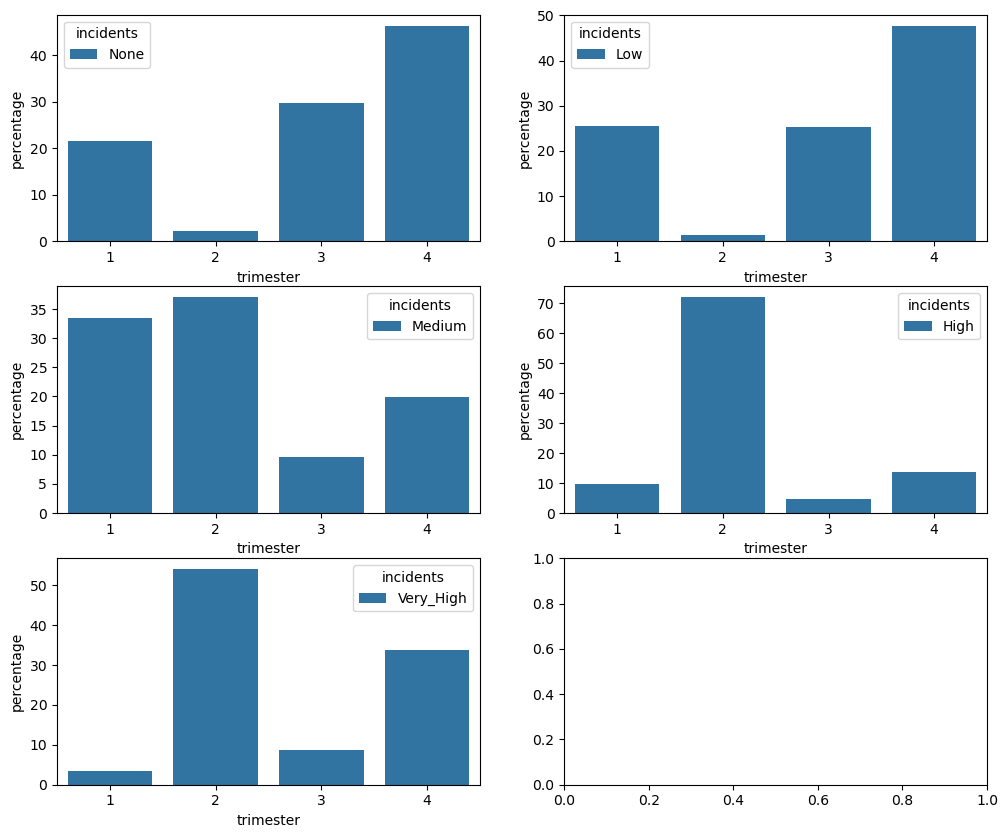

In [487]:
inc_trimester = df[['incidents','trimester']].groupby(by=['incidents','trimester']).agg(pd.Series.count).reset_index(name="count")

#sns.catplot(data=inc_trimester, kind="bar", x="trimester", y="count", hue="incidents")

inc_trimester['percentage'] = inc_trimester['count'] / inc_trimester.groupby('incidents')['count'].transform('sum') * 100

_None = inc_trimester.loc[inc_trimester['incidents'] == 'None']
_Low = inc_trimester.loc[inc_trimester['incidents'] == 'Low']
_Medium = inc_trimester.loc[inc_trimester['incidents'] == 'Medium']
_High = inc_trimester.loc[inc_trimester['incidents'] == 'High']
_Very_High = inc_trimester.loc[inc_trimester['incidents'] == 'Very_High']

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
sns.barplot(data=_None.reset_index(),  x="trimester", y="percentage", hue="incidents", ax=axs[0,0])
sns.barplot(data=_Low,  x="trimester", y="percentage", hue="incidents", ax=axs[0,1])
sns.barplot(data=_Medium,  x="trimester", y="percentage", hue="incidents", ax=axs[1,0])
sns.barplot(data=_High,  x="trimester", y="percentage", hue="incidents", ax=axs[1,1])
sns.barplot(data=_Very_High,  x="trimester", y="percentage", hue="incidents", ax=axs[2,0])

<AxesSubplot:xlabel='day_of_week', ylabel='percentage'>

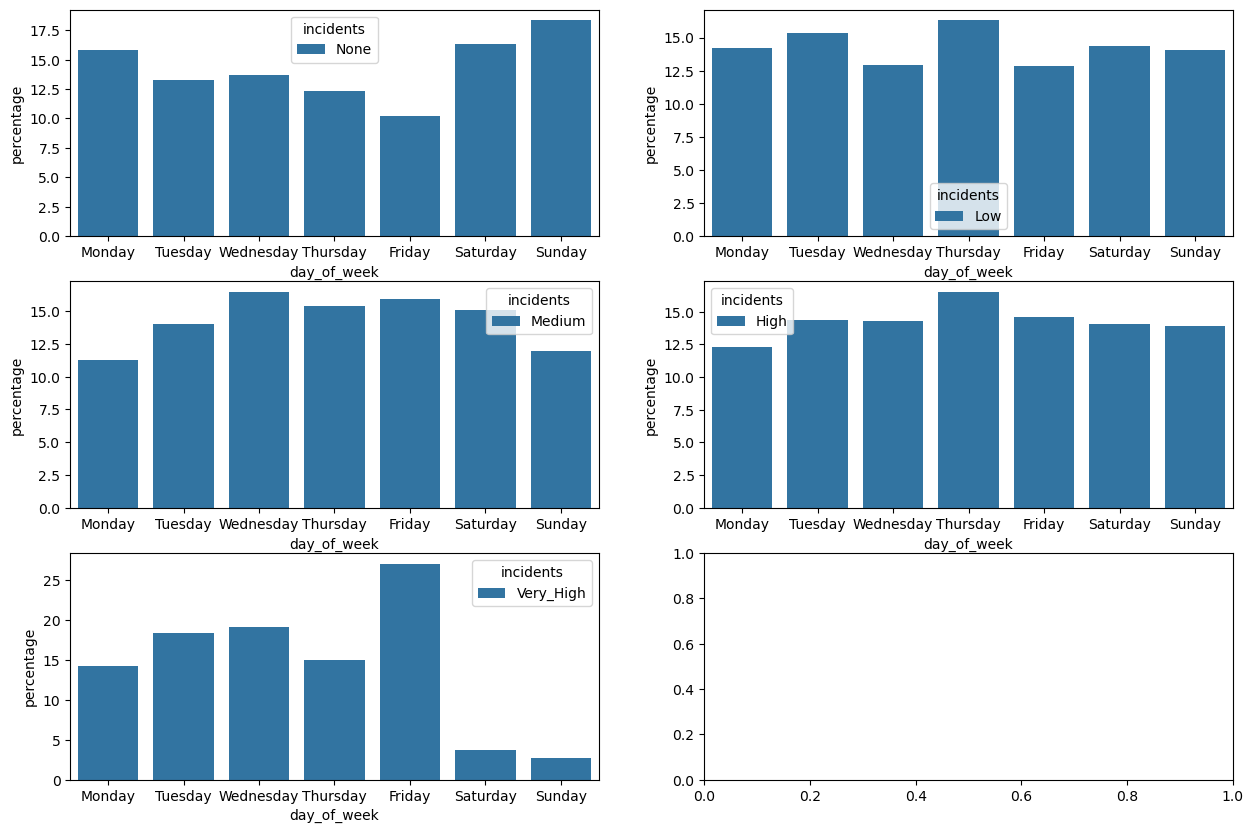

In [488]:
inc_day_of_week = df[['incidents','day_of_week']].groupby(by=['incidents','day_of_week']).agg(pd.Series.count).reset_index(name="count")

def dayOfWeekIntToString(dow):
    if dow == 0:
        return "Monday"
    elif dow == 1:
        return "Tuesday"
    elif dow == 2:
        return "Wednesday"
    elif dow == 3:
        return "Thursday"
    elif dow == 4:
        return "Friday"
    elif dow == 5:
        return "Saturday"
    else:
        return "Sunday"
    
inc_day_of_week['day_of_week'] = inc_day_of_week['day_of_week'].apply(dayOfWeekIntToString)
inc_day_of_week['percentage'] = inc_day_of_week['count'] / inc_day_of_week.groupby('incidents')['count'].transform('sum') * 100

_None = inc_day_of_week.loc[inc_day_of_week['incidents'] == 'None']
_Low = inc_day_of_week.loc[inc_day_of_week['incidents'] == 'Low']
_Medium = inc_day_of_week.loc[inc_day_of_week['incidents'] == 'Medium']
_High = inc_day_of_week.loc[inc_day_of_week['incidents'] == 'High']
_Very_High = inc_day_of_week.loc[inc_day_of_week['incidents'] == 'Very_High']

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
sns.barplot(data=_None,  x="day_of_week", y="percentage", hue="incidents", ax=axs[0,0])
sns.barplot(data=_Low,  x="day_of_week", y="percentage", hue="incidents", ax=axs[0,1])
sns.barplot(data=_Medium,  x="day_of_week", y="percentage", hue="incidents", ax=axs[1,0])
sns.barplot(data=_High,  x="day_of_week", y="percentage", hue="incidents", ax=axs[1,1])
sns.barplot(data=_Very_High,  x="day_of_week", y="percentage", hue="incidents", ax=axs[2,0])

<AxesSubplot:xlabel='is_non_working_day', ylabel='percentage'>

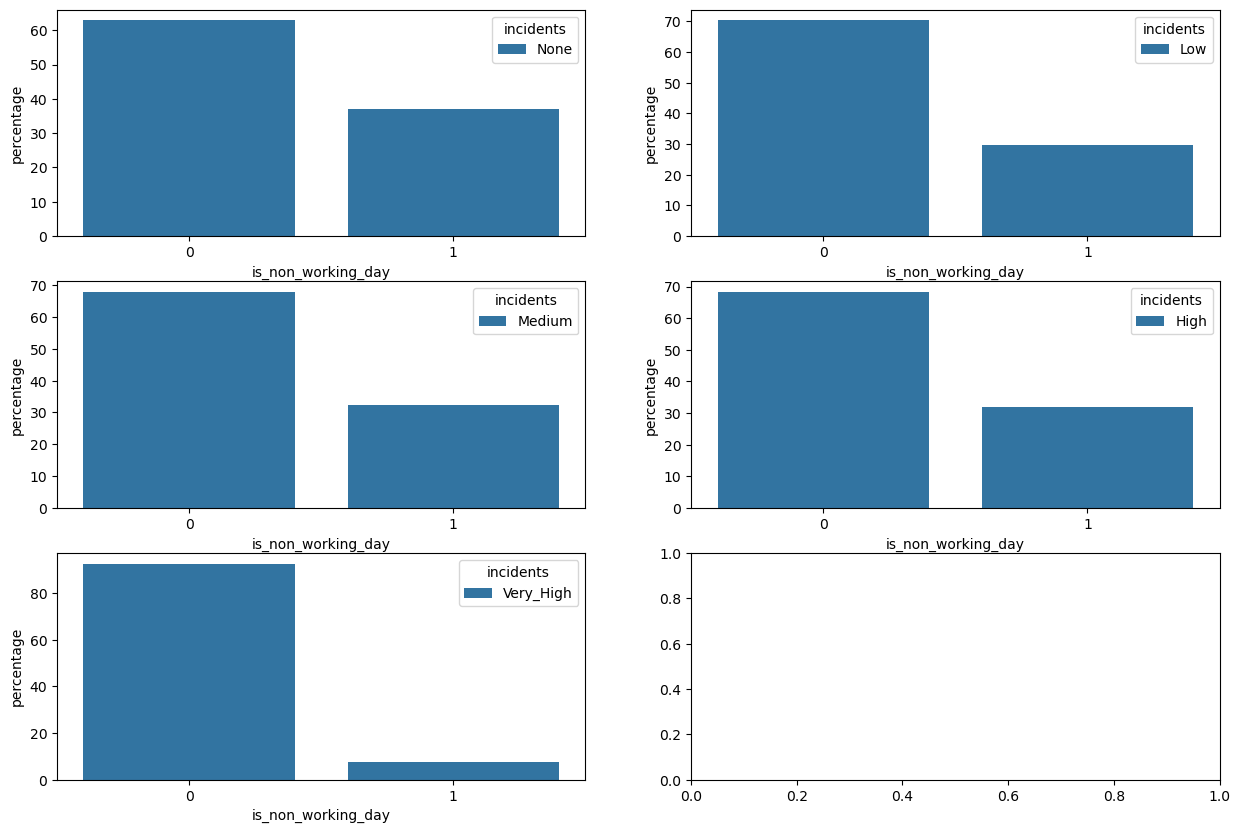

In [489]:
inc_is_non_working_day = df[['incidents','is_non_working_day']].groupby(by=['incidents','is_non_working_day']).agg(pd.Series.count).reset_index(name="count")

inc_is_non_working_day['percentage'] = inc_is_non_working_day['count'] / inc_is_non_working_day.groupby('incidents')['count'].transform('sum') * 100

_None = inc_is_non_working_day.loc[inc_is_non_working_day['incidents'] == 'None']
_Low = inc_is_non_working_day.loc[inc_is_non_working_day['incidents'] == 'Low']
_Medium = inc_is_non_working_day.loc[inc_is_non_working_day['incidents'] == 'Medium']
_High = inc_is_non_working_day.loc[inc_is_non_working_day['incidents'] == 'High']
_Very_High = inc_is_non_working_day.loc[inc_is_non_working_day['incidents'] == 'Very_High']

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
sns.barplot(data=_None,  x="is_non_working_day", y="percentage", hue="incidents", ax=axs[0,0])
sns.barplot(data=_Low,  x="is_non_working_day", y="percentage", hue="incidents", ax=axs[0,1])
sns.barplot(data=_Medium,  x="is_non_working_day", y="percentage", hue="incidents", ax=axs[1,0])
sns.barplot(data=_High,  x="is_non_working_day", y="percentage", hue="incidents", ax=axs[1,1])
sns.barplot(data=_Very_High,  x="is_non_working_day", y="percentage", hue="incidents", ax=axs[2,0])

<AxesSubplot:xlabel='hour', ylabel='count'>

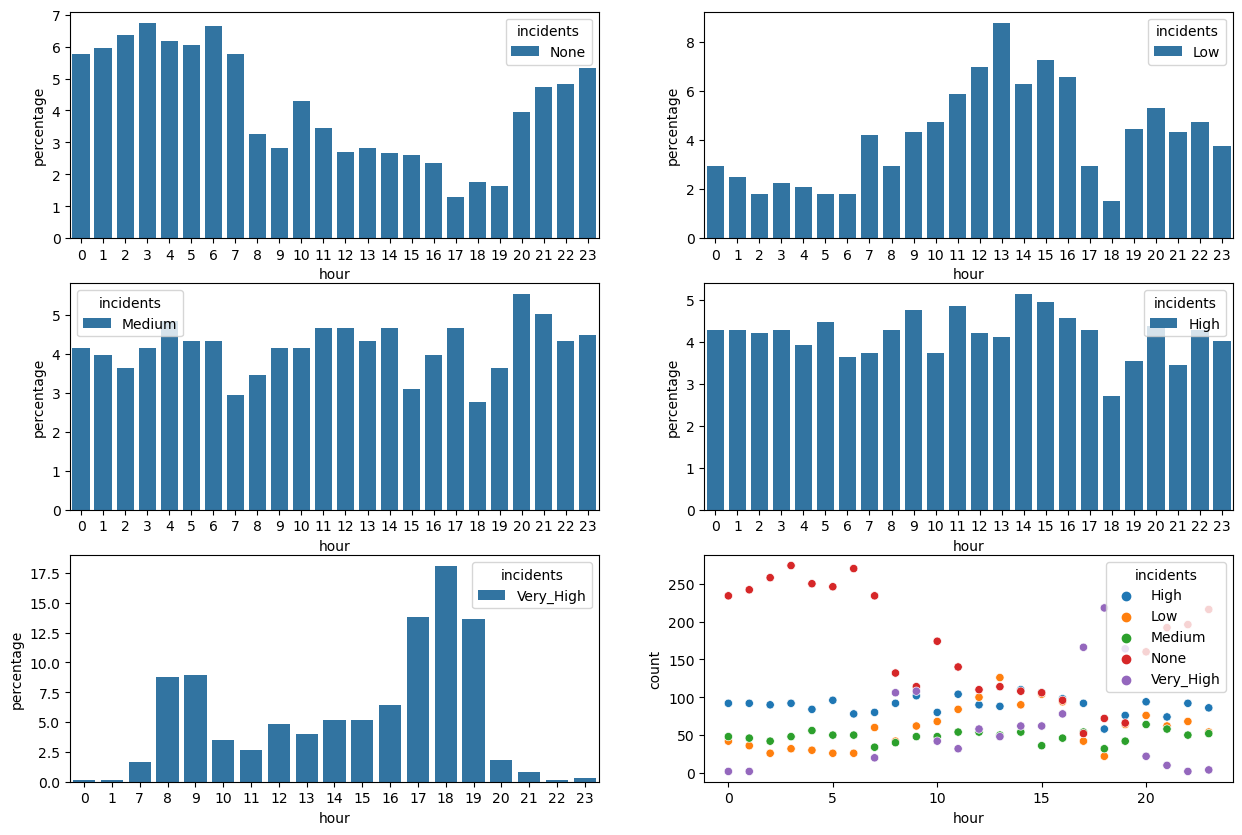

In [490]:
inc_hour = df[['incidents','hour']].groupby(by=['incidents','hour']).agg(pd.Series.count).reset_index(name="count")

inc_hour['percentage'] = inc_hour['count'] / inc_hour.groupby('incidents')['count'].transform('sum') * 100

_None = inc_hour.loc[inc_hour['incidents'] == 'None']
_Low = inc_hour.loc[inc_hour['incidents'] == 'Low']
_Medium = inc_hour.loc[inc_hour['incidents'] == 'Medium']
_High = inc_hour.loc[inc_hour['incidents'] == 'High']
_Very_High = inc_hour.loc[inc_hour['incidents'] == 'Very_High']

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
sns.barplot(data=_None,  x="hour", y="percentage", hue="incidents", ax=axs[0,0])
sns.barplot(data=_Low,  x="hour", y="percentage", hue="incidents", ax=axs[0,1])
sns.barplot(data=_Medium,  x="hour", y="percentage", hue="incidents", ax=axs[1,0])
sns.barplot(data=_High,  x="hour", y="percentage", hue="incidents", ax=axs[1,1])
sns.barplot(data=_Very_High,  x="hour", y="percentage", hue="incidents", ax=axs[2,0])
plt.plot()

sns.scatterplot(data=inc_hour, x="hour", y="count", hue="incidents")

In [491]:
def binHour(hour):
    if hour >= 20 and hour <= 7:
        return 0
    elif hour > 7 and hour <= 16:
        return 1
    else:
        return 2
df["hour_binned"] = df['hour'].apply(binHour)
df_test["hour_binned"] = df['hour'].apply(binHour)

In [492]:
"""
def binnDaHora(hora):
    if magnitude_of_delay == 'UNDEFINED': #horas mortas
        return 0;
    elif magnitude_of_delay == 'MODERATE':
        return 1;
    elif magnitude_of_delay == 'MAJOR':
        return 2;
    else:
        return -1;
    
df['magnitude_of_delay_cat'] = df['magnitude_of_delay'].apply(magnitude_of_delay_label_encoder)
df_test['magnitude_of_delay_cat'] = df_test['magnitude_of_delay'].apply(magnitude_of_delay_label_encoder) 
df.drop(['magnitude_of_delay'], axis=1, inplace=True)
df_test.drop(['magnitude_of_delay'], axis=1, inplace=True) 
"""

"\ndef binnDaHora(hora):\n    if magnitude_of_delay == 'UNDEFINED': #horas mortas\n        return 0;\n    elif magnitude_of_delay == 'MODERATE':\n        return 1;\n    elif magnitude_of_delay == 'MAJOR':\n        return 2;\n    else:\n        return -1;\n    \ndf['magnitude_of_delay_cat'] = df['magnitude_of_delay'].apply(magnitude_of_delay_label_encoder)\ndf_test['magnitude_of_delay_cat'] = df_test['magnitude_of_delay'].apply(magnitude_of_delay_label_encoder) \ndf.drop(['magnitude_of_delay'], axis=1, inplace=True)\ndf_test.drop(['magnitude_of_delay'], axis=1, inplace=True) \n"

In [493]:
def magnitude_of_delay_label_encoder(magnitude_of_delay):
    if magnitude_of_delay == 'UNDEFINED':
        return 0;
    elif magnitude_of_delay == 'MODERATE':
        return 1;
    elif magnitude_of_delay == 'MAJOR':
        return 2;
    else:
        return -1;
    
df['magnitude_of_delay_cat'] = df['magnitude_of_delay'].apply(magnitude_of_delay_label_encoder)
df_test['magnitude_of_delay_cat'] = df_test['magnitude_of_delay'].apply(magnitude_of_delay_label_encoder) 
df.drop(['magnitude_of_delay'], axis=1, inplace=True)
df_test.drop(['magnitude_of_delay'], axis=1, inplace=True) 

In [494]:
def luminosity_label_encoder(luminosity):
    if luminosity == 'DARK':
        return 0;
    elif luminosity == 'LOW_LIGHT':
        return 1;
    elif luminosity == 'LIGHT':
        return 2;
    else:
        return -1;
    
df['luminosity_cat'] = df['luminosity'].apply(luminosity_label_encoder)
df_test['luminosity_cat'] = df_test['luminosity'].apply(luminosity_label_encoder) 
df.drop(['luminosity'], axis=1, inplace=True)
df_test.drop(['luminosity'], axis=1, inplace=True) 

In [495]:
def avg_rain_label_encoder(avg_rain):
    if avg_rain == 'Sem Chuva':
        return 0;
    elif avg_rain == 'chuva fraca':
        return 1;
    elif avg_rain == 'chuva moderada':
        return 2;
    elif avg_rain == 'chuva forte':
        return 3;
    else:
        return -1;
    
df['avg_rain_cat'] = df['avg_rain'].apply(avg_rain_label_encoder)
df_test['avg_rain_cat'] = df_test['avg_rain'].apply(avg_rain_label_encoder)
df.drop(['avg_rain'], axis=1, inplace=True)
df_test.drop(['avg_rain'], axis=1, inplace=True)  

In [496]:
def incidents_label_encoder(incidents):
    if incidents == 'None':
        return 0
    elif incidents == 'Low':
        return 1
    elif incidents == 'Medium':
        return 2
    elif incidents == 'High':
        return 3
    elif incidents == 'Very_High':
        return 4
    else:
        return -1
    
def incidents_label_decoder(incidents_cat):
    if incidents_cat == 0:
        return 'None'
    elif incidents_cat == 1:
        return 'Low'
    elif incidents_cat == 2:
        return 'Medium'
    elif incidents_cat == 3:
        return 'High'
    elif incidents_cat == 4:
        return 'Very_High'
    else:
        return ""
    
df['incidents_cat'] = df['incidents'].apply(incidents_label_encoder)

In [497]:
df.head()

,delay_in_seconds,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,incidents,N206,IC5,N207-4,N310,...,day,day_of_week,week_of_month,month,trimester,hour_binned,magnitude_of_delay_cat,luminosity_cat,avg_rain_cat,incidents_cat
0,0,12.0,1013.0,70.0,1.0,None,0,0,0,0,...,15,0,2,3,1,2,0,0,0,0
1,385,12.0,1007.0,91.0,1.0,None,0,0,0,0,...,25,5,3,12,4,2,0,0,0,0
2,69,14.0,1025.0,64.0,0.0,Low,0,0,0,0,...,12,4,1,3,1,1,0,2,0,1
3,2297,15.0,1028.0,75.0,1.0,Very_High,0,0,0,0,...,29,2,4,9,3,1,2,2,0,4
4,0,27.0,1020.0,52.0,1.0,High,0,0,0,0,...,13,6,1,6,2,1,0,2,0,3


In [498]:
#for feature in ['magnitude_of_delay', 'luminosity', 'avg_rain', 'incidents']:
#    print(df[[feature, feature + '_cat']].drop_duplicates().sort_values(by=[feature + '_cat']).reset_index(drop=True),"\n")

In [499]:
#order columns
df.sort_index(axis=1, inplace=True)
df_test.sort_index(axis=1, inplace=True)

In [500]:
import math

def get_limits_iqr(frame : pd.DataFrame, column : str):
    q1 = frame[column].quantile(0.25)
    q3 = frame[column].quantile(0.75)
    iqr = q3-q1
    lim_inf = q1 - 1.5*iqr
    lim_sup = q3 + 1.5*iqr
    return lim_inf, lim_sup

def get_outliers_iqr(frame : pd.DataFrame, column : str):
    lim_inf, lim_sup = get_limits_iqr(frame, column)
    return frame.loc[(frame[column] < lim_inf) | (frame[column] > lim_sup)]

def convert_outlier_to_limit(val, lim_inf, lim_sup):
    counter = 0
    if val < lim_inf:
        return lim_inf
    elif val > lim_sup:
        return lim_sup
    else:
        return val

def applying_log(value):
    if (value == 0):
        return value
    return math.log2(value)

df['delay_in_seconds_log'] = df['delay_in_seconds'].apply(applying_log)
df_test['delay_in_seconds_log'] = df_test['delay_in_seconds'].apply(applying_log)
df.drop(['delay_in_seconds'], axis=1 ,inplace=True)
df_test.drop(['delay_in_seconds'], axis=1 ,inplace=True)

#Concatenation of training dataset with test dataset to find the global outliers
df_concat = pd.concat([df, df_test], ignore_index=True)

for attr in ['avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed']:
    linf, lsup = get_limits_iqr(df_concat, attr)
    df[attr] = df[attr].apply(convert_outlier_to_limit, args=(linf,lsup))
    df_test[attr] = df_test[attr].apply(convert_outlier_to_limit, args=(linf,lsup))

### Transformação do atributo "Magnitude of delay"

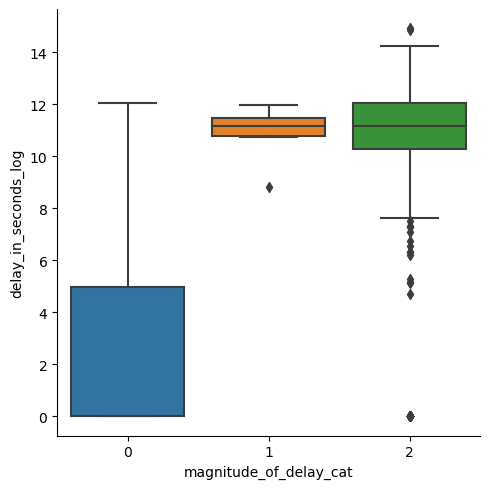

In [501]:
sns.catplot(y='delay_in_seconds_log', x='magnitude_of_delay_cat', data=df, kind='box')

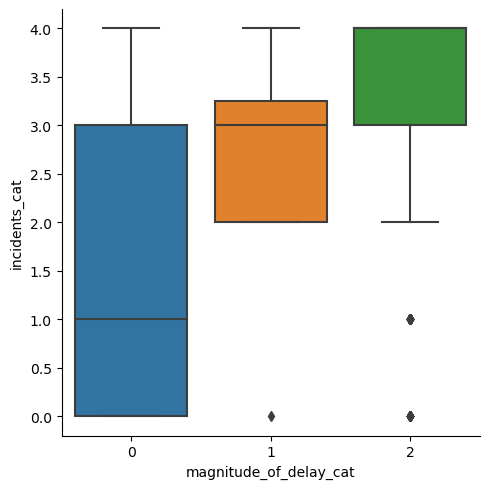

In [502]:
sns.catplot(y='incidents_cat', x='magnitude_of_delay_cat', data=df, kind='box')

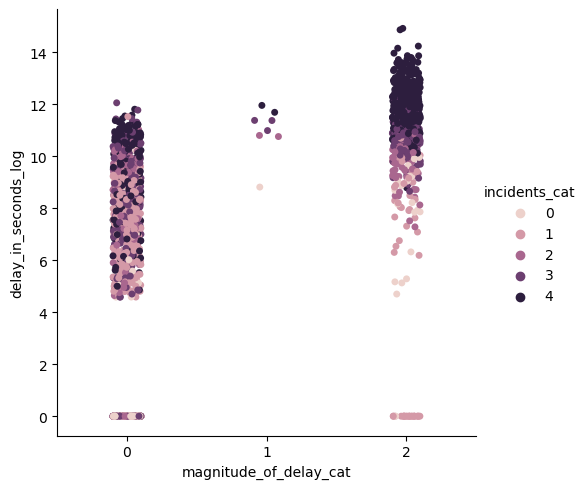

In [503]:
sns.catplot(data=df, x="magnitude_of_delay_cat", y="delay_in_seconds_log", hue="incidents_cat")

In [504]:
nr_divs = 3
df_concat = pd.concat([df, df_test], ignore_index=True)
leap = df_concat['delay_in_seconds_log'].agg(pd.Series.max) / nr_divs

In [505]:
df.columns

Index(['EM579', 'IC5', 'N101', 'N105', 'N206', 'N207-4', 'N309', 'N310',
       'R206', 'avg_atm_pressure', 'avg_humidity', 'avg_rain_cat',
       'avg_temperature', 'avg_wind_speed', 'day', 'day_of_week', 'hour',
       'hour_binned', 'incidents', 'incidents_cat', 'is_non_working_day',
       'luminosity_cat', 'magnitude_of_delay_cat', 'month', 'trimester',
       'week_of_month', 'delay_in_seconds_log'],
      dtype='object')

In [512]:
#For train dataset
for i in range (0, df.shape[0]):
    row = df.iloc[i]
    
    if row['incidents_cat'] == 0:
        df.at[i, 'delay_in_seconds_log'] = 0
        df.at[i, 'magnitude_of_delay_cat'] = 0
    else:
        delay = row['delay_in_seconds_log']
        aux = 0
        
        if delay > 0:
            aux = int(delay / leap) + 1
            if aux > nr_divs:
                aux = nr_divs
                
        df.at[i, 'magnitude_of_delay_cat'] = aux

#For test dataset
for i in range (0, df_test.shape[0]):
    row = df_test.iloc[i]
    delay = row['delay_in_seconds_log']
    aux = 0
    
    if delay > 0:
        aux = int(delay / leap) + 1
        if aux > nr_divs:
            aux = nr_divs
            
    df_test.at[i, 'magnitude_of_delay_cat'] = aux

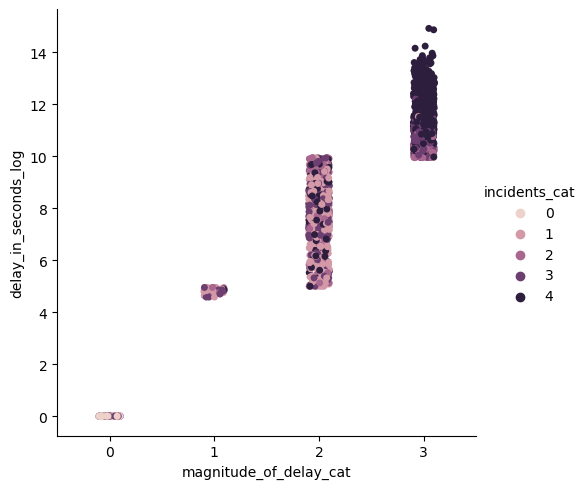

In [513]:
sns.catplot(data=df, x="magnitude_of_delay_cat", y="delay_in_seconds_log", hue="incidents_cat")

In [212]:
df.loc[(df['magnitude_of_delay_cat'] == 2) & (df['delay_in_seconds'] == 0)]['incidents'].value_counts()

Low     22
None     1
Name: incidents, dtype: int64

---
# Modelos
---

In [183]:
x = df.drop(['incidents','incidents_cat','magnitude_of_delay_cat','avg_humidity','week_of_month','avg_atm_pressure'],axis=1)
y = df['incidents_cat'].to_frame()

### Decision Tree

In [514]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

x = df.drop(['incidents','incidents_cat','magnitude_of_delay_cat','avg_humidity','avg_atm_pressure','hour'],axis=1)
y = df['incidents_cat'].to_frame()

clf = DecisionTreeClassifier(random_state=2022, criterion='gini', max_depth=1000)
scores = cross_val_score(clf, x, y, cv=10)
print(scores)
print('RESULT: %0.2f accuracy with a standard deviation of %0.2f' % (scores.mean(), scores.std()))
print(scores.mean())

[0.89  0.924 0.922 0.922 0.93  0.934 0.91  0.902 0.906 0.946]
RESULT: 0.92 accuracy with a standard deviation of 0.02
0.9186


In [ ]:
best_accuracy = 0
best_criterion = ""
best_max_depth = 0

for i in [1,3,5,7,9,11,13,15,20,25,30,35,40,50,60,70,80,100,200,500,750,1000,1500]:
    for c in ["gini","entropy"]:
        clf = DecisionTreeClassifier(random_state=2022, criterion=c, max_depth=i)
        scores = cross_val_score(clf, x, y, cv=10)
        new_acc = scores.mean()
        if new_acc > best_accuracy:
            best_accuracy = new_acc
            best_criterion = c
            best_max_depth = i

print("Best accuracy:", best_accuracy)
print("best_criterion:", best_criterion)
print("best_max_depth:", best_max_depth)

### Random Forest

In [542]:
#clf = RandomForestClassifier(random_state=RANDOM_SEED,max_depth=1500)
clf = RandomForestClassifier(random_state=RANDOM_SEED,bootstrap=False, max_depth=90, n_estimators=200)
#clf = RandomForestClassifier(bootstrap=False, max_depth=70, n_estimators=2000,random_state=2022)

#x = df.drop(['incidents','incidents_cat','magnitude_of_delay_cat','avg_atm_pressure','avg_humidity','hour_binned'],axis=1)
x = df[['avg_atm_pressure', 'avg_temperature', 'day', 'day_of_week', 'hour', 'magnitude_of_delay_cat', 'month', 'trimester', 'delay_in_seconds_log', 'EM579', 'IC5', 'N101', 'N105', 'N206', 'N207-4', 'N309', 'N310', 'R206']]
y = df['incidents_cat'].to_frame()

skf = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
skf.get_n_splits(x, y)

print(skf)
clf_accu_stratified = []
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(x_train, y_train.values.ravel())
    clf_accu_stratified.append(clf.score(x_test, y_test))
print('List of possible accuracy:', clf_accu_stratified) 
print('\nMaximum Accuracy That can be obtained from this model is:',max(clf_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',    min(clf_accu_stratified)*100, '%')
print('\nOverall Accuracy:',    statistics.mean(clf_accu_stratified)*100, '%')
print('\nStandard Deviation is:', statistics.stdev(clf_accu_stratified))

StratifiedKFold(n_splits=10, random_state=2022, shuffle=True)
List of possible accuracy: [0.94, 0.944, 0.924, 0.934, 0.952, 0.938, 0.942, 0.928, 0.956, 0.944]

Maximum Accuracy That can be obtained from this model is: 95.6 %

Minimum Accuracy: 92.4 %

Overall Accuracy: 94.02 %

Standard Deviation is: 0.00986351300951584


In [534]:
from sklearn.model_selection import RandomizedSearchCV

x = df[['avg_atm_pressure', 'avg_humidity', 'avg_temperature', 'day', 'day_of_week', 'hour', 'magnitude_of_delay_cat', 'month', 'trimester', 'week_of_month', 'delay_in_seconds_log', 'EM579', 'IC5', 'N101', 'N105', 'N206', 'N207-4', 'N309', 'N310', 'R206']]
y = df['incidents_cat'].to_frame()


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state': [RANDOM_SEED]
                 }
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 10 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=RANDOM_SEED, n_jobs = -1)
# Fit the random search model
rf_random.fit(x, y.values.ravel())
'''
from random import randint

random_grid={'max_depth': list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features': [randint(1,7)],
              'criterion':['gini','entropy'],
              'min_samples_leaf':[randint(1,4)],
              'min_samples_split':np.arange(2, 10, step=2),
              'bootstrap' : [True, False],
              'random_state': [RANDOM_SEED]
            }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter=500, cv = 10, random_state=RANDOM_SEED, n_jobs = -1, scoring='accuracy')
# Fit the random search model
rf_random.fit(x, y.values.ravel())'''

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['log2', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'random_state': [2022]}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=2022; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=2022; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=2022; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=400, random_state=2022; total time=   1.4s
[CV] END bootst

"\nfrom random import randint\n\nrandom_grid={'max_depth': list(np.arange(10, 100, step=10)) + [None],\n              'n_estimators':np.arange(10, 500, step=50),\n              'max_features': [randint(1,7)],\n              'criterion':['gini','entropy'],\n              'min_samples_leaf':[randint(1,4)],\n              'min_samples_split':np.arange(2, 10, step=2),\n              'bootstrap' : [True, False],\n              'random_state': [RANDOM_SEED]\n            }\n\n# Use the random grid to search for best hyperparameters\n# First create the base model to tune\nrf = RandomForestClassifier()\n# Random search of parameters, using 3 fold cross validation, \n# search across 100 different combinations, and use all available cores\nrf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter=500, cv = 10, random_state=RANDOM_SEED, n_jobs = -1, scoring='accuracy')\n# Fit the random search model\nrf_random.fit(x, y.values.ravel())"

In [535]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=False, max_depth=70, n_estimators=2000,
                       random_state=2022)


In [ ]:
skf = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
skf.get_n_splits(x, y)
clf_accu_stratified = []

best_accuracy = 0
best_criterion = ""
best_max_depth = 0

for i in [20,200,300,400,500,600,700,800,900,1100,1200,1300,1400,1600,1700]:
    for c in ["gini","entropy"]:
        clf = RandomForestClassifier(random_state=RANDOM_SEED, criterion=c, max_depth=i)
        
        for train_index, test_index in skf.split(x, y):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            clf.fit(x_train, y_train.values.ravel())
            clf_accu_stratified.append(clf.score(x_test, y_test))
        
        print('\n-------------------')
        print('max depth:',i)
        print('criterion:',c)
        print('List of possible accuracy:', clf_accu_stratified) 
        print('\nMaximum Accuracy That can be obtained from this model is:',max(clf_accu_stratified)*100, '%')
        print('\nMinimum Accuracy:',    min(clf_accu_stratified)*100, '%')
        print('\nOverall Accuracy:',    statistics.mean(clf_accu_stratified)*100, '%')
        print('\nStandard Deviation is:', statistics.stdev(clf_accu_stratified))
        print('\n-------------------')
            
        new_acc = statistics.mean(clf_accu_stratified)*100
        if new_acc > best_accuracy:
            best_accuracy = new_acc
            best_criterion = c
            best_max_depth = i
        
        clf_accu_stratified.clear()

print("Best overall accuracy:", best_accuracy)
print("best_criterion:", best_criterion)
print("best_max_depth:", best_max_depth)

In [ ]:
df_test.columns

In [543]:
#x_train_data = df.drop(['incidents','incidents_cat','magnitude_of_delay_cat'],axis=1)
#y_train_data = df['incidents_cat'].to_frame()
#clf.fit(x_train_data, y_train_data)

clf = RandomForestClassifier(random_state=RANDOM_SEED,bootstrap=False, max_depth=90, n_estimators=200)

x = df[['avg_atm_pressure', 'avg_temperature', 'day', 'day_of_week', 'hour', 'magnitude_of_delay_cat', 'month', 'trimester', 'delay_in_seconds_log', 'EM579', 'IC5', 'N101', 'N105', 'N206', 'N207-4', 'N309', 'N310', 'R206']]
y = df['incidents_cat'].to_frame()
test_data = df_test[['avg_atm_pressure', 'avg_temperature', 'day', 'day_of_week', 'hour', 'magnitude_of_delay_cat', 'month', 'trimester', 'delay_in_seconds_log', 'EM579', 'IC5', 'N101', 'N105', 'N206', 'N207-4', 'N309', 'N310', 'R206']]

clf.fit(x,y)
predictions = clf.predict(test_data)    
    
submissao = pd.DataFrame({"RowId" : range(1,1207), "Incidents": predictions}).set_index('RowId')
submissao['Incidents'] = submissao['Incidents'].apply(incidents_label_decoder)
submissao.to_csv("submissoes/submissao5.csv")

/tmp/ipykernel_25846/2430428597.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x,y)


### Random Forest + Backward Feature Selection + StratifiedKFold

In [ ]:
#RandomForestClassifier(bootstrap=False, max_depth=90, n_estimators=200,random_state=2022)

In [51]:
print(df.columns)
print(df.shape)

Index(['EM579', 'IC5', 'N101', 'N105', 'N206', 'N207-4', 'N309', 'N310',
       'R206', 'avg_atm_pressure', 'avg_humidity', 'avg_rain_cat',
       'avg_temperature', 'avg_wind_speed', 'day', 'day_of_week',
       'delay_in_seconds', 'hour', 'hour_binned', 'incidents', 'incidents_cat',
       'is_non_working_day', 'luminosity_cat', 'magnitude_of_delay_cat',
       'month', 'trimester', 'week_of_month'],
      dtype='object')
(5000, 27)


In [518]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

roads = ['EM579', 'IC5', 'N101', 'N105', 'N206', 'N207-4', 'N309', 'N310','R206']
X = df.drop(['incidents','incidents_cat'] + roads,axis=1)
y = df['incidents_cat'].to_frame()

# #Selecting the Best important features according to Logistic Regression
results = list()
for i in range(1,X.shape[1]):
    rfe_selector = RFE(estimator=RandomForestClassifier(random_state=RANDOM_SEED),n_features_to_select = i, step = 1)
    rfe_selector.fit(X, y.values.ravel())
    results.append(X.columns[rfe_selector.get_support()].to_list())
    
for r in results:
    print(r)

['delay_in_seconds_log']
['month', 'delay_in_seconds_log']
['day', 'month', 'delay_in_seconds_log']
['day', 'magnitude_of_delay_cat', 'month', 'delay_in_seconds_log']
['day', 'magnitude_of_delay_cat', 'month', 'trimester', 'delay_in_seconds_log']
['avg_atm_pressure', 'day', 'magnitude_of_delay_cat', 'month', 'trimester', 'delay_in_seconds_log']
['avg_atm_pressure', 'avg_humidity', 'day', 'magnitude_of_delay_cat', 'month', 'trimester', 'delay_in_seconds_log']
['avg_atm_pressure', 'avg_humidity', 'day', 'magnitude_of_delay_cat', 'month', 'trimester', 'week_of_month', 'delay_in_seconds_log']
['avg_atm_pressure', 'avg_humidity', 'avg_temperature', 'day', 'magnitude_of_delay_cat', 'month', 'trimester', 'week_of_month', 'delay_in_seconds_log']
['avg_atm_pressure', 'avg_humidity', 'avg_temperature', 'day', 'hour', 'magnitude_of_delay_cat', 'month', 'trimester', 'week_of_month', 'delay_in_seconds_log']
['avg_atm_pressure', 'avg_humidity', 'avg_temperature', 'day', 'day_of_week', 'hour', 'magni

In [519]:
all_scores = list()

for r in results:
    r = r + roads
    X = df[r]
    y = df['incidents_cat'].to_frame()
    
    skf = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
    skf.get_n_splits(X, y)

    clf = RandomForestClassifier(random_state=RANDOM_SEED)
    clf_accu_stratified = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train.values.ravel())
        clf_accu_stratified.append(clf.score(X_test, y_test))
    
    all_scores.append((r, # columns
                       clf_accu_stratified, # all scores
                       max(clf_accu_stratified)*100, # maximum accuracy
                       min(clf_accu_stratified)*100, # minimum accuracy
                       statistics.mean(clf_accu_stratified)*100, #overall accuracy
                       statistics.stdev(clf_accu_stratified))) #standard deviation

In [520]:
best_score = 0
best_columns = []

for score in all_scores:
    if score[4] > best_score:
        best_score = score[4]
        best_columns = score[0]
        
print("best overally accuracy:", best_score)
print("columns:", best_columns)

best overally accuracy: 93.30000000000001
columns: ['avg_atm_pressure', 'avg_humidity', 'avg_temperature', 'day', 'day_of_week', 'hour', 'magnitude_of_delay_cat', 'month', 'trimester', 'week_of_month', 'delay_in_seconds_log', 'EM579', 'IC5', 'N101', 'N105', 'N206', 'N207-4', 'N309', 'N310', 'R206']


In [521]:
f = open("results/results.txt", "a")
for score in all_scores:
    f.write('{\n\tColumns: ' + str(score[0]) + ',\n\tAll scores: ' + str(score[1]) + ',\n\t Maximum Accuracy:' + str(score[2]) + ',\n\tMinimum Accuracy: ' + str(score[3]) + ',\n\tOverall Accuracy: ' + str(score[4]) + ',\n\tStd dev:' + str(score[5]) + '\n}\n')
f.close()

### Rede Neuronal

In [ ]:
from sklearn.neural_network import MLPClassifier
x = df[['avg_atm_pressure', 'avg_humidity', 'avg_temperature', 'day', 'day_of_week', 'delay_in_seconds_log', 'hour', 'magnitude_of_delay_cat', 'month', 'trimester', 'week_of_month', 'EM579', 'IC5', 'N101', 'N105', 'N206', 'N207-4', 'N309', 'N310', 'R206']]
y = df[["cardio"]]

scaler_x = MinMaxScaler(feature_range=(0,1)).fit(x)
x_scaled = pd.DataFrame(scaler_x.transform(x[x.columns]),columns=x.columns)

In [ ]:
mlp = MLPClassifier(alpha=1e-5,max_iter=500, random_state=RANDOM_SEED)
params_mlp = {
            'activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [
             (1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,),(12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)
            ]
        }


skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
skf.get_n_splits(x_scaled, y)
accu_stratified = []

for train_index, test_index in skf.split(x_scaled, y):
    x_train, x_test = x_scaled.iloc[train_index], x_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    grid_search = GridSearchCV(estimator=mlp,
                           param_grid= params_mlp,
                           cv = skf,
                           scoring="accuracy",
                           refit="True",
                           verbose = 1)
    grid_search.fit(x_train, y_train.values.ravel())
    accu_stratified.append(grid_search.score(x_test, y_test))
    
print('List of possible accuracy:', accu_stratified) 
print('\nMaximum Accuracy That can be obtained from this model is:',max(accu_stratified)*100, '%')
print('\nMinimum Accuracy:',    min(accu_stratified)*100, '%')
print('\nOverall Accuracy:',    statistics.mean(accu_stratified)*100, '%')
print('\nStandard Deviation is:', statistics.stdev(accu_stratified))

In [ ]:
"""
def build_model(activation="relu",learning_rate=0.01):
    #Create a sequential
    model = Sequential()
    model.add(Dense(16, input_dim=len(x_train_data.columns), activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1, activation="relu"))

    #Compile the model
    #
    model.compile(
        loss="mae",
        optimizer = tf.optimizers.Adam(learning_rate),
        metrics = ["mae","mse"])
    return model
"""

In [ ]:
"""
model = build_model()
model.summary()
TUNING_DICT = {
    "activation": ["relu", "sigmoid"],
    "learning_rate": [0.02, 0.001]
}
"""

In [ ]:
"""
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

model = KerasRegressor(build_fn=build_model, epochs=5,batch_size=5)
grid_search = GridSearchCV(estimator=model,
                           param_grid= TUNING_DICT,
                           cv = kf,
                           scoring="neg_mean_absolute_error",
                           refit="True",
                           verbose = 1)

#grid_search.fit(x_train,y_train,validation_split=0.2)
"""

In [ ]:
"""
print("Best : %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_["mean_test_score"]
stds = grid_search.cv_results_["std_test_score"]
params = grid_search.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f  (%f) with: %r" % (mean, stdev, param))
"""

### XGBoost


In [382]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold
kfold  = KFold(n_splits=5)

In [383]:
processor_best = make_pipeline(
    VarianceThreshold(),
    SelectKBest(f_classif, k = 21)
)

In [384]:
from sklearn.model_selection import KFold

def train_and_evaluate(x_train, train_targets, x_val , val_targets, **params):
    model = make_pipeline(
        processor_best,
        XGBClassifier(n_jobs=-1,eval_metric='mlogloss',use_label_encoder=False, **params)
    )
    model.fit(x_train, train_targets.values.ravel())
    train_accuracy = model.score(x_train, train_targets.values.ravel())
    val_accuracy = model.score(x_val, val_targets)
    return model, train_accuracy, val_accuracy

In [385]:
x = df.drop(['incidents','incidents_cat','magnitude_of_delay_cat','avg_atm_pressure','is_non_working_day'],axis=1)
y = df['incidents_cat'].to_frame()

#Hyperparameter Tuning
def test_params_kfold(n_splits, **params):
    train_accuracys, val_accuracys, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(x):
        x_train, train_targets = x.iloc[train_idxs], y.iloc[train_idxs]
        x_val, val_targets = x.iloc[val_idxs], y.iloc[val_idxs]
        model, train_accuracy, val_accuracy = train_and_evaluate(x_train, train_targets, x_val, val_targets,**params)
        models.append(model)
        train_accuracys.append(train_accuracy)
        val_accuracys.append(val_accuracy)
    print("Train Accuracy: {}, Validation Accuracy: {}".format(np.mean(train_accuracys), np.mean(val_accuracys)))
    return models

In [386]:
%%time
test_params_kfold(5,
        random_state=RANDOM_SEED,
        n_estimators=500,
        learning_rate=0.9,
        max_depth=20)

/home/alexandrof/Apps/anaconda3/envs/env/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/alexandrof/Apps/anaconda3/envs/env/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/alexandrof/Apps/anaconda3/envs/env/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/alexandrof/Apps/anaconda3/envs/env/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/alexandrof/Apps/anaconda3/envs/env/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 

Train Accuracy: 1.0, Validation Accuracy: 0.9296000000000001
CPU times: user 1min 53s, sys: 3.17 s, total: 1min 57s
Wall time: 25.7 s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('variancethreshold', VarianceThreshold()),
                                  ('selectkbest', SelectKBest(k=21))])),
                 ('xgbclassifier',
                  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, early_stopping_rounds=None,
                                enable_categorical=False, eval_metric='mlogloss',
                                feature_types=No...pu_id=-1,
                                grow_policy='depthwise', importance_type=None,
                                interaction_constraints='', learning_rate=0.9,
                                max_bin=256, max_cat_threshold=64,
                                max_cat_to_onehot=4, max_delta_step=0,
                                max_depth=20, max_leaves=0, min_child_weight=1,
                              

### Support Vector Machine

In [457]:
from sklearn.svm import SVC

x = df.drop(['incidents','incidents_cat','magnitude_of_delay_cat','avg_atm_pressure','is_non_working_day'],axis=1)
y = df['incidents_cat'].to_frame()

svc = SVC(random_state=RANDOM_SEED)

params_svc = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
skf.get_n_splits(x, y)

print(skf)
svc_accu_stratified = []
i = 0
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    grid_search = GridSearchCV(estimator = svc,
                           param_grid = params_svc,
                           cv = skf,
                           scoring = "accuracy",
                           refit = "True",
                           verbose = 1)
    grid_search.fit(x_train, y_train.values.ravel())
    svc_accu_stratified.append(grid_search.score(x_test, y_test))
    
print('List of possible accuracy:', svc_accu_stratified) 
print('\nMaximum Accuracy That can be obtained from this model is:',max(svc_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',    min(svc_accu_stratified)*100, '%')
print('\nOverall Accuracy:',    statistics.mean(svc_accu_stratified)*100, '%')
print('\nStandard Deviation is:', statistics.stdev(svc_accu_stratified))

StratifiedKFold(n_splits=5, random_state=2022, shuffle=True)
Fitting 5 folds for each of 48 candidates, totalling 240 fits
